# Text Classification

I previously explored using various ML model techniques to classify text. This notebook continues to explore various approaches to Text Classification using the Keras Deep Learning API. Using the dataset `spam_assassin_csv`, I evaluated the performance of various model architectures in classifying an email as spam or not based on its contents. The reason I chose this dataset is because I've always been curious how real email services determine spam. By learning more about some deep learning applications in text classification I want to better understand how the real thing works.

*Note*: Some of this code is inspired by the sample code provided on Dr. Mazidi's Github. I used her code to guide my exploration of how to use Keras. Also, my laptop is quite weak and really struggled with fitting these models. It regularly ran out of RAM and took hours to run even a few epochs so that is why some of the models were not able to finish fitting. I had to stop running them because my laptop could not handle the load. I did my best to work around these issues where possible, but my laptop's performance was a serious bottleneck to my work.

In [3]:
# For text preprocessing
import pandas as pd
import numpy as np

# For data plotting
import seaborn as sb
import matplotlib.pyplot as plt

# To split the given dataset into training and testing sets
from sklearn.model_selection import train_test_split

# For applying ML models
import tensorflow as tf
from keras import layers, models, Input, Model
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.layers import TextVectorization


# for evaluating model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Preprocessing Data

In [4]:
# parses  data into dataframe
data = pd.read_csv('spam_assassin.csv')

print(data.head())

                                                text  target
0  From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...       0
1  From gort44@excite.com Mon Jun 24 17:54:21 200...       1
2  From fork-admin@xent.com Mon Jul 29 11:39:57 2...       1
3  From dcm123@btamail.net.cn Mon Jun 24 17:49:23...       1
4  From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...       0


In [5]:
# Splits data into 80% training, 20% testing
train, test = train_test_split(data, test_size=0.2, random_state=1234)
print('Training Dataset Shape:\t', train.shape)
print('Testing Dataset Shape:\t', test.shape)

Training Dataset Shape:	 (4636, 2)
Testing Dataset Shape:	 (1160, 2)


### Label Distributions

The data set has a total of 5796 data points. Using the sklearn `train_test_split()` method the dataset is split into train and test sets. Based on the distributions seen in the images saved, the sets have approximately double the number of non-spam emails as spam. Trained using these sets, the model should be able to predict whether a test data sample should have a spam (1) or non-spam(0) classification.

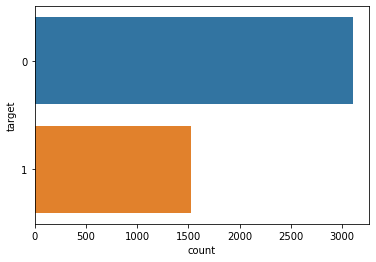

In [4]:
trainPlot = sb.countplot(y = train['target'])
trainPlot.get_figure().savefig('trainPlot.png')

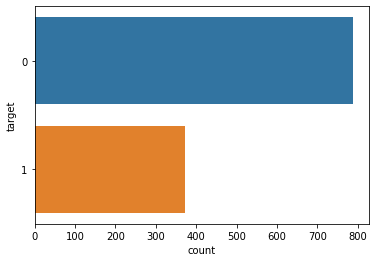

In [5]:
testPlot = sb.countplot(y = test['target'])
trainPlot.get_figure().savefig('testPlot.png')

### Data Tokenization

In [6]:
# Tokenization
numClasses = 2
maxToks = 25000

tokenizer = Tokenizer(num_words = maxToks)
tokenizer.fit_on_texts(train.text)

trainX = tokenizer.texts_to_matrix(train.text, mode='tfidf')
testX = tokenizer.texts_to_matrix(test.text, mode='tfidf')

labelEncoder = LabelEncoder()
labelEncoder.fit(train.target)
trainY = labelEncoder.transform(train.target)
testY = labelEncoder.transform(test.target)

print('train shapes:\t', trainX.shape, '\t', trainY.shape)
print('test shapes:\t', testX.shape, '\t', testY.shape)

train shapes:	 (4636, 25000) 	 (4636,)
test shapes:	 (1160, 25000) 	 (1160,)


## Sequential Model

In [24]:
batchSize = 100

seqModel = models.Sequential()
seqModel.add(layers.Dense(12, input_dim=maxToks, kernel_initializer='normal', activation='relu'))
seqModel.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))

seqModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 
history = seqModel.fit(trainX, trainY, batch_size=batchSize, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
38/38 [==============================] - 2s 35ms/step - loss: 0.3444 - accuracy: 0.8511 - val_loss: 0.0993 - val_accuracy: 0.9763
Epoch 2/20
38/38 [==============================] - 1s 16ms/step - loss: 0.0442 - accuracy: 0.9941 - val_loss: 0.0269 - val_accuracy: 0.9935
Epoch 3/20
38/38 [==============================] - 1s 15ms/step - loss: 0.0130 - accuracy: 0.9992 - val_loss: 0.0158 - val_accuracy: 0.9978
Epoch 4/20
38/38 [==============================] - 1s 19ms/step - loss: 0.0067 - accuracy: 0.9992 - val_loss: 0.0113 - val_accuracy: 0.9978
Epoch 5/20
38/38 [==============================] - 1s 16ms/step - loss: 0.0041 - accuracy: 0.9997 - val_loss: 0.0092 - val_accuracy: 0.9989
Epoch 6/20
38/38 [==============================] - 1s 15ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9989
Epoch 7/20
38/38 [==============================] - 1s 17ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 0.9989
Epoch 8/20
38

### Evaluation

In [26]:
score = seqModel.evaluate(testX, testY, batch_size=batchSize, verbose=1)
print('Test Accuracy: ', score[1])

12/12 [==============================] - 0s 19ms/step - loss: 0.0088 - accuracy: 0.9966
Test Accuracy:  0.9965517520904541


#### Conclusion
This model clearly worked very well, with its incredibly high accuracy on the test dataset. This is obviously not a sure indicator of its performance on other data, but does show great promise for Sequential models ran on this dataset.

### Prediction

Since this is a binary classification dataset, the model's predicitons need to be converted to 0s or 1s. To do this I round them to 1 if the classification is > 0.5 and to 0 if it is below. 

In [27]:
preds = seqModel.predict(testX)
labelPreds = [1 if curr > 0.5 else 0 for curr in preds]

37/37 [==============================] - 1s 7ms/step


#### Evaluating Predictions

In [30]:
print('Precision Score:\t%.3f%%' % (precision_score(testY, labelPreds) * 100))
print('Accuracy Score:\t\t%.3f%%' % (accuracy_score(testY, labelPreds) * 100))
print('Recall Score:\t\t%.3f%%' % (recall_score(testY, labelPreds) * 100))
print('F1 Score:\t\t%.3f%%' % (f1_score(testY, labelPreds) * 100))

Precision Score:	99.461%
Accuracy Score:		99.655%
Recall Score:		99.461%
F1 Score:		99.461%


## RNN (Recurrent Neural Network)

In [8]:
maxToks = 25000

rnnModel = models.Sequential()
rnnModel.add(layers.Embedding(maxToks, 32))
rnnModel.add(layers.SimpleRNN(32))
rnnModel.add(layers.Dense(1, activation='sigmoid'))

In [9]:
batchSize = 100
rnnModel.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = rnnModel.fit(trainX, trainY, epochs=20, batch_size=batchSize, validation_split=0.2)

Epoch 1/20
38/38 [==============================] - 2097s 55s/step - loss: 0.6357 - accuracy: 0.6753 - val_loss: 0.6462 - val_accuracy: 0.6541
Epoch 2/20
38/38 [==============================] - 2068s 54s/step - loss: 0.6323 - accuracy: 0.6753 - val_loss: 0.6449 - val_accuracy: 0.6541
Epoch 3/20
38/38 [==============================] - 2068s 54s/step - loss: 0.6314 - accuracy: 0.6753 - val_loss: 0.6462 - val_accuracy: 0.6541
Epoch 4/20
38/38 [==============================] - 2071s 55s/step - loss: 0.6310 - accuracy: 0.6753 - val_loss: 0.6452 - val_accuracy: 0.6541
Epoch 5/20
38/38 [==============================] - 2071s 54s/step - loss: 0.6317 - accuracy: 0.6753 - val_loss: 0.6526 - val_accuracy: 0.6541
Epoch 6/20
38/38 [==============================] - 2070s 54s/step - loss: 0.6313 - accuracy: 0.6753 - val_loss: 0.6499 - val_accuracy: 0.6541
Epoch 7/20
38/38 [==============================] - 2071s 55s/step - loss: 0.6313 - accuracy: 0.6753 - val_loss: 0.6449 - val_accuracy: 0.6541

Although this model did not finish trianing for the full 20 epochs, the validation accuracy plateaued at 65.41%. This means further training of the model is not really necessary since this is approximately the lowest the loss can get.

In [ ]:
preds = rnnModel.predict(testX)
labelPreds = [1 if curr > 0.5 else 0 for curr in preds]

In [ ]:
print('Precision Score:\t%.3f%%' % (precision_score(testY, labelPreds) * 100))
print('Accuracy Score:\t\t%.3f%%' % (accuracy_score(testY, labelPreds) * 100))
print('Recall Score:\t\t%.3f%%' % (recall_score(testY, labelPreds) * 100))
print('F1 Score:\t\t%.3f%%' % (f1_score(testY, labelPreds) * 100))

In this case, since the model was interrupted and my laptop is struggling with running the model, there were some issues with evaluating the model on the test data set. But by looking at the performance of the model on the validation dataset, it can be seen that this RNN model was significantly less accurate than the Sequential model. This model has a 65.41% accuracy on the validation set while the Sequential model had a 99.89% acccuracy on its validation set. Although there is no guarantee that the validation data is roughly indicative of the test data, in this case, since the train, validation, and test data sets are chosen randomly from the same uniform distribution of data, we can look at the performance on the validation data set as a fair indicator of the model's performance.

#### Conclusion
It is fairly clear that the RNN model is less accurate than the Sequential model on this dataset.

## Adding an Embedding Layer

In [8]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
textDataset = tf.data.Dataset.from_tensor_slices(train['text'].to_numpy()).batch(128)
vectorizer.adapt(textDataset)

In [9]:
vocab = vectorizer.get_vocabulary()
wordInd = dict(zip(vocab, range(len(vocab))))

In [10]:
EMBEDDING_DIM = 128
MAX_SEQUENCE_LENGTH = 200

embeddingLayer = layers.Embedding(len(wordInd) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)

In [14]:
# add more layers
intSeqInput = Input(shape=(None,), dtype="int64")
embeddedSeqs = embeddingLayer(intSeqInput)
x = layers.Conv1D(128, 5, activation="relu")(embeddedSeqs)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(numClasses, activation="softmax")(x)
embModel = Model(intSeqInput, preds)
embModel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         2560128   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                            

In [15]:
batchSize = 128
embModel.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
embModel.fit(trainX, trainY, batch_size=batchSize, epochs=10, validation_split=0.2)

Epoch 1/10
29/29 [==============================] - 1254s 43s/step - loss: 0.5821 - acc: 0.6845 - val_loss: 0.4213 - val_acc: 0.8481
Epoch 2/10
29/29 [==============================] - 1199s 41s/step - loss: 0.3605 - acc: 0.8657 - val_loss: 0.2870 - val_acc: 0.9235
Epoch 3/10
29/29 [==============================] - 1256s 43s/step - loss: 0.2324 - acc: 0.9194 - val_loss: 0.1821 - val_acc: 0.9386
Epoch 4/10
29/29 [==============================] - 1394s 48s/step - loss: 0.2110 - acc: 0.9229 - val_loss: 0.1657 - val_acc: 0.9450
Epoch 5/10


Although this model did not finish trianing for the full 20 epochs, the validation accuracy was approaching >90% and steadily increasing. Based on this, I decided to stop the model since it showed that this model was quite accurate on the data.

In this case, since the model was interrupted and my laptop is struggling with running the model, there were again some issues with evaluating the model on the test data set. Compared to the RNN model, this model using an embedding layer was significantly more accurate. The one downside of stopping the model fitting early is that I don't know for sure whether this model could get more or less ccurate than the first Sequential model. Although there is no guarantee that the validation data is roughly indicative of the test data, in this case, since the performance on the validation set is atill quite high (95.5% as last seen), it can be assumed that this is a helpful technique.

#### Conclusion
It is fairly clear that this model is more accurate than the RNN model on this dataset but it is unclear if the model with an embedding layer will be more accurate than the first Sequential model.

## Final Conclusion

Unfortunately, the hardware that is avaliable to me is severely underpowered for the tasks I was trying to evaluate for this project. This ccaused me to have to stop some of the models' fitting processes before they were completed. However, even despite being able to get concrete test data performance statistics on some of these models, I was able to get a decent look at their performance. The Sequential model performed leagues better than the RNN model, and it is unclear whether the model with embedding would have outperformed the Sequential model but it definitely outperformed the RNN model. Overall, this project gave me another look into using existing ML tools for realistic text classification problems.